# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pickle
from tqdm import tqdm

# Custom
from config import model_config
from regression import reg

# Stats
from sklearn.feature_selection import(
	RFECV, SequentialFeatureSelector
)
from sklearn.linear_model import (
	LinearRegression, LogisticRegression,
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score,
)
from sklearn.pipeline import (
	Pipeline
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer, FunctionTransformer
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global vars
SEED = 123
TEST_SIZE = 0.25
HEATMAP_COLORS = sns.diverging_palette(h_neg=250, h_pos=359, as_cmap=True)
SIGNIFICANCE_CUTOFF = 0.05

# Import/Preprocess Data

In [5]:
with open(Path('../data/prediction_data.pkl'), 'rb') as f:
	data = pickle.load(f)
	
X = data.get('X')
y = data.get('y')
body_features = data.get('body_features')
cardio_features = data.get('cardio_features')

print(X.shape)

X.head()

(90, 21)


,density_visceral_fat,mass_visceral_fat,volume_intermuscular_fat,density_intermuscular_fat,density_bone,mass_bone,bmi,emphysema_volume_950hu,lung_volume,extrapulmonary_artery_volume,...,artery_vein_ratio,bv5,pb_larger_10,a_diameter,pv_a,heart_volume,airway_ratio,ild_volume,age,gender_cl_Male
PE1_0,-0.804596,-1.006961,1.331630,-0.066012,-1.754047,1.134155,0.207862,0.480081,1.724862,5.199338,...,-0.996942,0.124882,1.843089,0.947761,1.199407,1.818949,-0.337578,-0.519639,-0.099108,1.0
PE12_0,-0.132313,0.893337,1.197132,-1.003148,-0.597841,1.032652,0.066012,0.138304,0.980188,0.817043,...,0.100068,0.794604,0.518666,-0.640149,1.252273,0.097809,0.469267,0.926287,-0.382953,1.0
PE12_1,0.132313,1.353718,0.215841,1.008759,-0.103421,1.345373,0.066012,-0.883335,-0.621845,-0.066318,...,-0.046248,-1.748358,0.735412,0.030429,-0.169806,0.474218,1.594807,1.566161,-0.382953,1.0
PE14_0,1.412188,-0.675649,-1.039624,1.354934,-0.169270,0.766997,-0.514471,1.051576,1.240579,-0.292203,...,-0.101339,0.178621,0.072902,-0.200470,0.102281,0.113720,-0.634274,-5.199338,-1.008759,0.0
PE15_0,1.252120,-5.199338,-1.617132,1.252120,1.003148,-0.624630,-5.199338,0.156703,-1.004953,-0.828968,...,0.330129,0.595698,-0.975373,-1.654127,0.334016,-1.195727,0.077566,-0.078812,-5.199338,0.0


In [4]:
y.head()

,total_clot_burden,centralartery,apical_rs1,posterior_rs2,anterior_rs3,lateral_rs4,medial_rs5,superior_rs6,medial_basal_rs7,anterior_basal_rs8,...,posterior_basal_rs10,apical_ls1,posterior_ls2,anterior_ls3,superior_ls4,inferior_ls5,superior_ls6,anteromedial_basal_ls7_8,lateral_basal_ls9,posterior_basal_ls10
PE1_0,1.323152,1.115911,1.622695,1.628534,1.682629,1.645900,1.692823,1.684104,0.868466,1.145468,...,1.150860,-5.199338,-5.199338,1.006726,2.009940,-5.199338,-5.199338,0.722378,1.189252,1.003403
PE12_0,-0.114961,-0.195764,0.629894,-5.199338,0.523349,1.433511,1.275896,0.383191,-5.199338,1.620714,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE12_1,0.018764,0.258934,-5.199338,-5.199338,-5.199338,0.731753,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338
PE14_0,-0.064683,0.075220,-5.199338,-5.199338,-5.199338,0.683778,-5.199338,-5.199338,-5.199338,1.250845,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.264394,-5.199338,-5.199338,0.853690,-5.199338
PE15_0,-0.405327,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.553623


In [5]:
print(body_features)
print(cardio_features)

['density_visceral_fat', 'mass_visceral_fat', 'volume_intermuscular_fat', 'density_intermuscular_fat', 'density_bone', 'mass_bone', 'bmi']
['emphysema_volume_950hu', 'lung_volume', 'extrapulmonary_artery_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10', 'a_diameter', 'pv_a', 'heart_volume', 'airway_ratio', 'ild_volume']


# OLS Regression Functions

We loop through each of the numerical target variables (the various clot burden measures for different locations, as well as the total clot burden), and perform a simple single-variable OLS regression. Shown below are the statistically significant results at the 95% confidence level.

In [6]:
def combine_feat_and_controls(features=None, controls=None):
	feat_set = set(features)
	if controls is None:
		control_set = set()
	else:
		control_set = set(controls)
	all_feat = list(feat_set.union(control_set))
	return all_feat

def ols_regression(Xdata, Ydata, targets, features=None, controls=None):
	
	all_features = combine_feat_and_controls(features, controls)
	X_temp = sm.add_constant(Xdata.loc[:, all_features])
		
	ols_results = list()

	for target in targets:
		y_temp = Ydata[[target]]
		
		single_model_results = list()
		for feat in features:
			regression_results = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')
			results_df = pd.DataFrame({
				'coef': regression_results.params,
				'pvalue': regression_results.pvalues,
				'nobs': regression_results.nobs,
				'r2_adj': regression_results.rsquared_adj,
			}).stack()
			results_df.index = [(item[0].replace(feat, 'variable'), item[1]) for item in results_df.index.tolist()]
			results_df.name = (target, feat)
			single_model_results.append(results_df)

		all_model_results = pd.concat(single_model_results, axis=1).transpose()
		all_model_results.columns = ['_'.join(item) for item in all_model_results.columns.to_list()]
		all_model_results.index.names = ['y_var', 'x_var']
		ols_results.append(all_model_results)

	ols_cb = pd.concat(ols_results, axis=0)
	
	ols_cb = ols_cb.sort_index()
	
	return ols_cb

def ols_identify_significant(ols_results, signif_cutoff, out_path, display=False):
	signif_cb_bodycomp = (
		ols_results.loc[ols_results.variable_pvalue <= signif_cutoff, :]
		.sort_values(by='variable_pvalue')
	)
	signif_cb_bodycomp.to_csv(out_path)
	if display:
		return (
			signif_cb_bodycomp
			.style
				.background_gradient(subset='variable_pvalue')
				.format("{:.3f}")
		)
	else:
		return None

def ols_heatmap(ols, out_path, subtitle, figsize=(9, 7)):
	fig, axs = plt.subplots(figsize=figsize)
	sns.heatmap(
		ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_coef.unstack(level=1),
		annot=ols.loc[ols['variable_pvalue']<=SIGNIFICANCE_CUTOFF].variable_pvalue.unstack(level=1), 
		annot_kws={"fontsize":8},
		fmt = '.3f',
		center=0.0,
		cmap=HEATMAP_COLORS,
	)

	for t in axs.texts: 
		t.set_text('p=' + t.get_text())

	axs.set_ylabel('Clot Burden Measure')
	axs.set_xlabel('Body Composition Measure')
	plt.suptitle('Coefficient Heatmap: red=positive coef, blue=negative coef', fontsize=16)
	plt.title(subtitle, fontsize=14)
	plt.tight_layout()
	plt.savefig(out_path)
	plt.show()
	
def r2_adjusted(r2, n, k):
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Body Composition

## Univariate Regressions

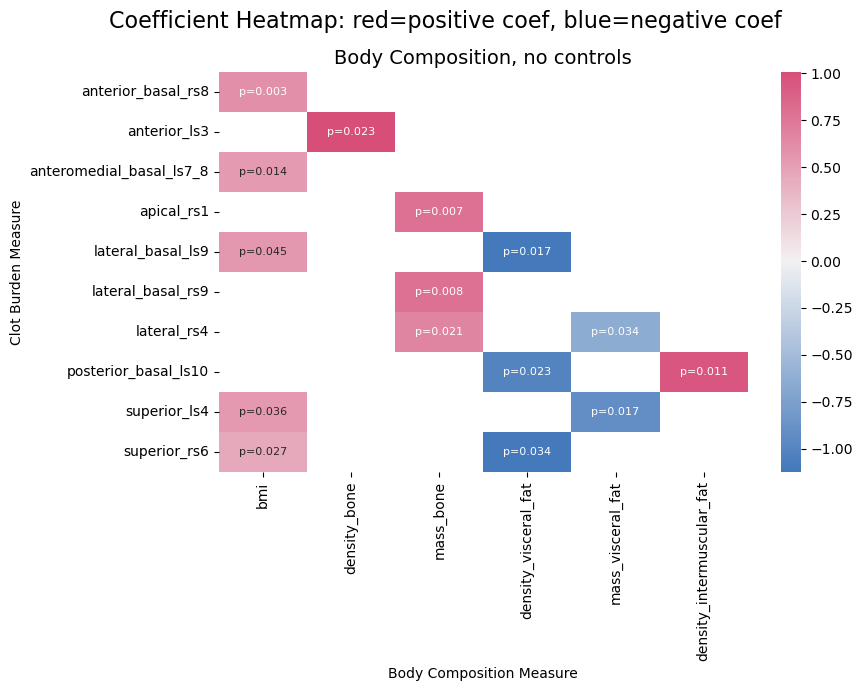

In [7]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features
)

plot_subtitle = 'Body Composition, no controls'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=None.png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=None.csv')

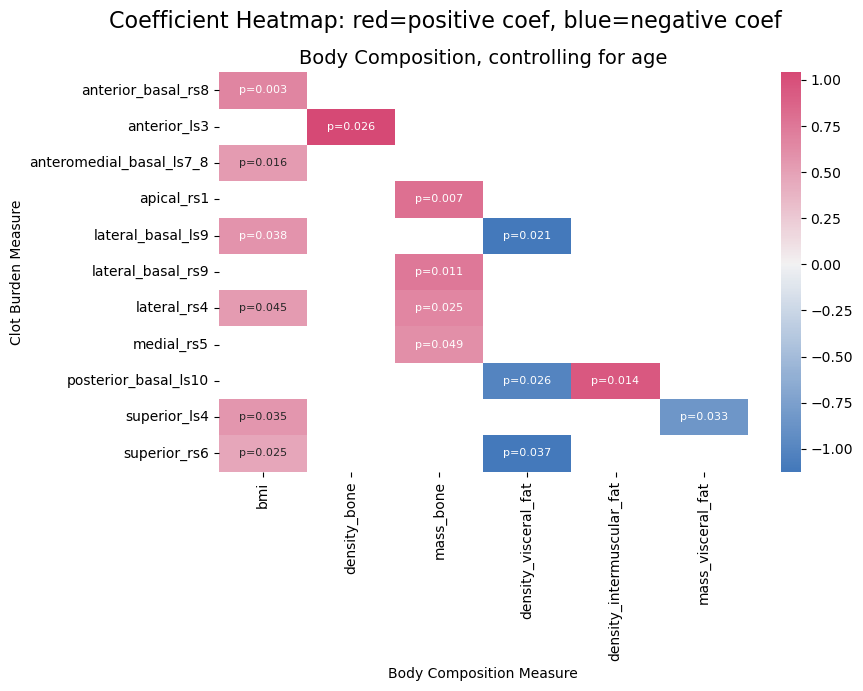

In [8]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age']
)

plot_subtitle = 'Body Composition, controlling for age'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[age].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[age].csv')

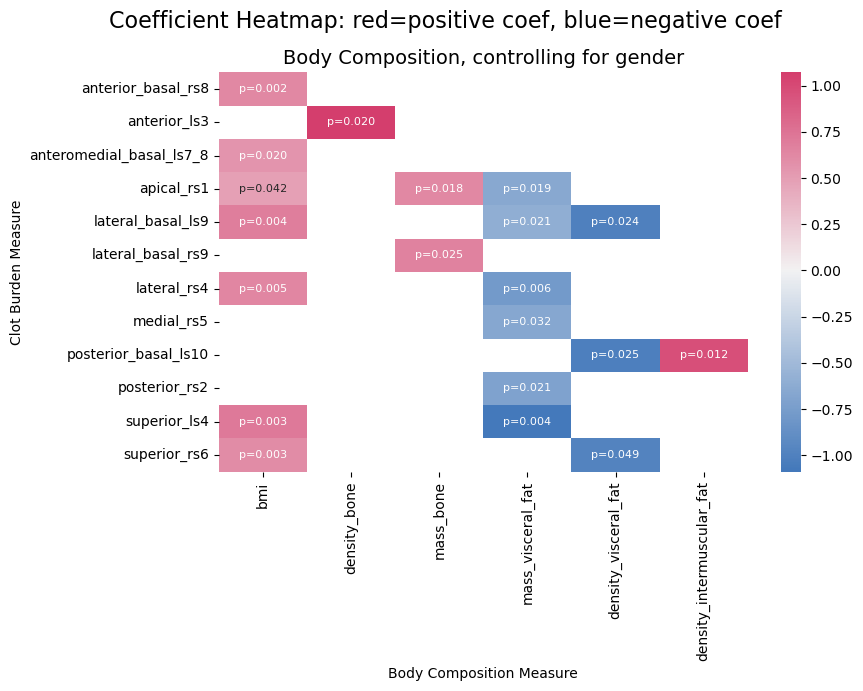

In [9]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for gender'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[gender_cl_Male].csv')

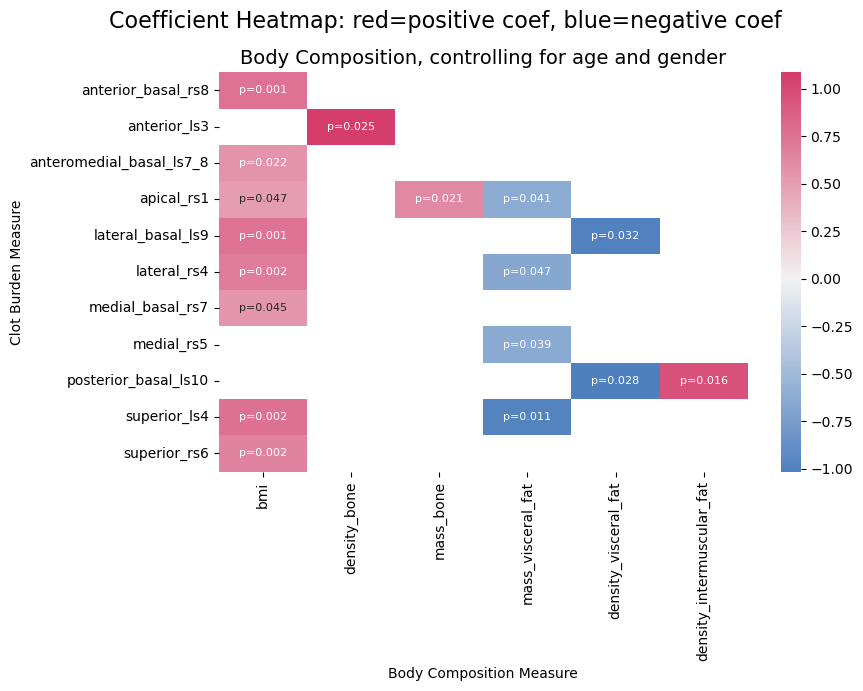

In [10]:
ols = ols_regression(
	Xdata=X, Ydata=y, 
	targets=y.columns,
	features=body_features,
	controls=['age', 'gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for age and gender'

ols_heatmap(ols, '../figures/heatmap_OLS_body_controls=[age, gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_body_controls=[age, gender_cl_Male].csv')

## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [39]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[body_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_results

{'total_clot_burden': ['mass_bone'],
 'centralartery': ['mass_bone'],
 'apical_rs1': ['density_visceral_fat', 'mass_visceral_fat', 'mass_bone'],
 'posterior_rs2': ['mass_bone'],
 'anterior_rs3': ['density_intermuscular_fat'],
 'lateral_rs4': ['mass_bone'],
 'medial_rs5': ['density_visceral_fat', 'mass_bone'],
 'superior_rs6': ['density_visceral_fat'],
 'medial_basal_rs7': ['density_bone'],
 'anterior_basal_rs8': ['density_visceral_fat', 'mass_visceral_fat', 'bmi'],
 'lateral_basal_rs9': ['mass_bone'],
 'posterior_basal_rs10': ['mass_visceral_fat'],
 'apical_ls1': ['density_bone'],
 'posterior_ls2': ['density_intermuscular_fat'],
 'anterior_ls3': ['density_visceral_fat', 'density_bone'],
 'superior_ls4': ['mass_visceral_fat'],
 'inferior_ls5': ['density_visceral_fat'],
 'superior_ls6': ['mass_visceral_fat', 'density_bone'],
 'anteromedial_basal_ls7_8': ['density_visceral_fat'],
 'lateral_basal_ls9': ['density_visceral_fat',
  'mass_visceral_fat',
  'volume_intermuscular_fat',
  'density

In [47]:
rfecv_regressions = pd.DataFrame()

for target in y.columns:
	x_vars = rfecv_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)
	
rfecv_regressions.to_csv('../output/regressions/ols_rfecv_selected_body.csv')
rfecv_regressions

coef          pval  \
y                        X                                                   
total_clot_burden        const                     -0.124775  4.148461e-01   
                         mass_bone                  0.406416  2.644883e-02   
centralartery            const                     -1.276210  1.368397e-05   
                         mass_bone                  0.525748  5.581970e-03   
apical_rs1               const                     -2.890541  5.606057e-20   
                         density_visceral_fat      -0.595297  8.497259e-03   
                         mass_visceral_fat         -0.398070  1.671391e-01   
                         mass_bone                  0.695052  1.139047e-03   
posterior_rs2            const                     -3.204291  5.409169e-24   
                         mass_bone                  0.460659  3.722484e-02   
anterior_rs3             const                     -3.206007  5.554814e-24   
                         density_intermuscular_fat -0.725609  1.254079e-01   
lateral_rs4              const                     -2.649416  1.606834e-16   
                         mass_bone                  0.659237  2.361327e-03   
medial_rs5               const                     -3.784154  2.184297e-40   
                         density_visceral_fat      -0.451521  3.923360e-02   
                         mass_bone                  0.489650  1.891929e-02   
superior_rs6             const                     -2.649627  2.140284e-17   
                         density_visceral_fat      -0.881532  5.480650e-05   
medial_basal_rs7         const                     -3.992648  2.284009e-47   
                         density_bone               0.642663  1.073121e-01   
anterior_basal_rs8       const                     -2.823044  6.895789e-19   
                         density_visceral_fat      -0.601365  3.419106e-03   
                         mass_visceral_fat         -0.464501  3.562420e-02   
                         bmi                        0.497458  2.814949e-03   
lateral_basal_rs9        const                     -2.886068  3.425843e-19   
                         mass_bone                  0.579932  1.091409e-02   
posterior_basal_rs10     const                     -3.076351  3.550243e-21   
                         mass_visceral_fat         -0.310610  2.681015e-01   
apical_ls1               const                     -3.389095  8.365531e-27   
                         density_bone               0.480939  2.139377e-01   
posterior_ls2            const                     -3.918465  1.065774e-40   
                         density_intermuscular_fat  0.316370  4.642165e-01   
anterior_ls3             const                     -3.458741  4.131144e-30   
                         density_visceral_fat      -0.394184  1.894851e-01   
                         density_bone               0.778051  1.248457e-02   
superior_ls4             const                     -3.266169  1.207457e-24   
                         mass_visceral_fat         -0.368074  1.643627e-01   
inferior_ls5             const                     -4.130140  1.264419e-53   
                         density_visceral_fat      -0.408053  1.361183e-01   
superior_ls6             const                     -2.703547  1.205999e-16   
                         mass_visceral_fat          0.459003  5.274687e-02   
                         density_bone               0.630336  7.045813e-02   
anteromedial_basal_ls7_8 const                     -2.702038  1.126303e-16   
                         density_visceral_fat      -0.533763  1.199223e-02   
lateral_basal_ls9        const                     -2.997670  6.703550e-21   
                         density_visceral_fat      -1.121054  1.723195e-02   
                         mass_visceral_fat         -0.457264  8.346969e-02   
                         volume_intermuscular_fat   0.183431  7.243291e-01   
                         density_intermuscular_fat  0.686365  2.672420e-01   


#### Sequential Feature Selection

In [45]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[body_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_results

{'total_clot_burden': array(['density_bone', 'mass_bone'], dtype=object),
 'centralartery': array(['mass_bone'], dtype=object),
 'apical_rs1': array(['density_visceral_fat', 'mass_bone'], dtype=object),
 'posterior_rs2': array(['mass_bone'], dtype=object),
 'anterior_rs3': array(['density_visceral_fat', 'density_bone'], dtype=object),
 'lateral_rs4': array(['density_visceral_fat', 'mass_visceral_fat', 'mass_bone', 'bmi'],
       dtype=object),
 'medial_rs5': array(['density_visceral_fat', 'mass_bone'], dtype=object),
 'superior_rs6': array(['density_visceral_fat', 'mass_bone'], dtype=object),
 'medial_basal_rs7': array(['mass_visceral_fat', 'density_bone'], dtype=object),
 'anterior_basal_rs8': array(['density_visceral_fat', 'mass_visceral_fat', 'bmi'], dtype=object),
 'lateral_basal_rs9': array(['mass_bone'], dtype=object),
 'posterior_basal_rs10': array(['density_visceral_fat'], dtype=object),
 'apical_ls1': array(['density_bone'], dtype=object),
 'posterior_ls2': array(['mass_bone']

In [48]:
sfs_fwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_fwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	sfs_fwd_regressions = pd.concat((sfs_fwd_regressions, res), axis=0)
	
sfs_fwd_regressions.to_csv('../output/regressions/ols_sfs_fwd_selected_body.csv')
sfs_fwd_regressions

coef          pval  \
y                        X                                                   
total_clot_burden        const                     -0.123427  4.146381e-01   
                         density_bone               0.301957  1.327091e-01   
                         mass_bone                  0.337343  4.123903e-02   
centralartery            const                     -1.276210  1.368397e-05   
                         mass_bone                  0.525748  5.581970e-03   
apical_rs1               const                     -2.891000  5.824954e-20   
                         density_visceral_fat      -0.441479  5.280553e-02   
                         mass_bone                  0.559512  3.425023e-03   
posterior_rs2            const                     -3.204291  5.409169e-24   
                         mass_bone                  0.460659  3.722484e-02   
anterior_rs3             const                     -3.199181  5.908186e-24   
                         density_visceral_fat      -0.467739  8.810766e-02   
                         density_bone               0.535914  2.860901e-02   
lateral_rs4              const                     -2.642845  2.575371e-17   
                         density_visceral_fat      -0.479580  3.478038e-02   
                         mass_visceral_fat         -0.667270  8.681930e-03   
                         mass_bone                  0.781528  9.771563e-04   
                         bmi                        0.530502  2.236797e-03   
medial_rs5               const                     -3.784154  2.184297e-40   
                         density_visceral_fat      -0.451521  3.923360e-02   
                         mass_bone                  0.489650  1.891929e-02   
superior_rs6             const                     -2.648434  2.136805e-17   
                         density_visceral_fat      -0.817749  1.338559e-04   
                         mass_bone                  0.314004  1.673973e-01   
medial_basal_rs7         const                     -3.991024  4.639231e-48   
                         mass_visceral_fat          0.384963  8.077897e-02   
                         density_bone               0.739073  6.725381e-02   
anterior_basal_rs8       const                     -2.823044  6.895789e-19   
                         density_visceral_fat      -0.601365  3.419106e-03   
                         mass_visceral_fat         -0.464501  3.562420e-02   
                         bmi                        0.497458  2.814949e-03   
lateral_basal_rs9        const                     -2.886068  3.425843e-19   
                         mass_bone                  0.579932  1.091409e-02   
posterior_basal_rs10     const                     -3.074445  6.656596e-21   
                         density_visceral_fat      -0.175958  5.465956e-01   
apical_ls1               const                     -3.389095  8.365531e-27   
                         density_bone               0.480939  2.139377e-01   
posterior_ls2            const                     -3.917640  3.976530e-42   
                         mass_bone                  0.259413  3.034472e-01   
anterior_ls3             const                     -3.461543  1.453276e-30   
                         density_bone               0.690773  7.281860e-03   
superior_ls4             const                     -3.266169  1.207457e-24   
                         mass_visceral_fat         -0.368074  1.643627e-01   
inferior_ls5             const                     -4.128154  9.932827e-54   
                         density_visceral_fat      -0.471262  8.451235e-02   
                         density_bone               0.288034  1.520485e-01   
superior_ls6             const                     -2.706207  1.550865e-16   
                         mass_bone                  0.433817  4.692206e-02   
anteromedial_basal_ls7_8 const                     -2.702038  1.126303e-16   
                         density_visceral_fat      -0.533763  1.199223e-02   


# Cardiopulmonary

## Univariate Regressions

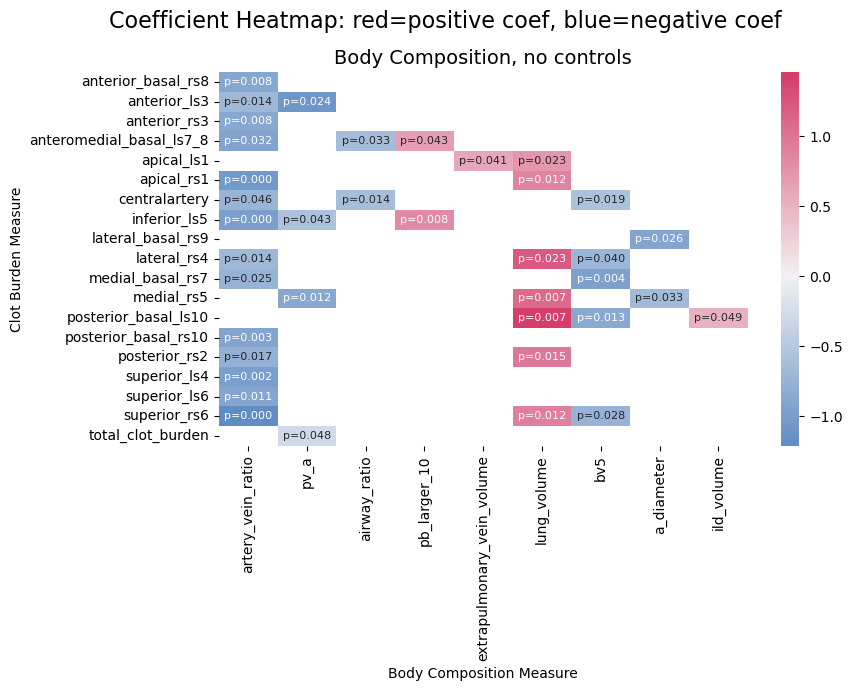

In [15]:
ols = ols_regression(
	Xdata=X,
	Ydata=y,  
	targets=y.columns,
	features=cardio_features
)

plot_subtitle = 'Body Composition, no controls'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=None.png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=None.csv')

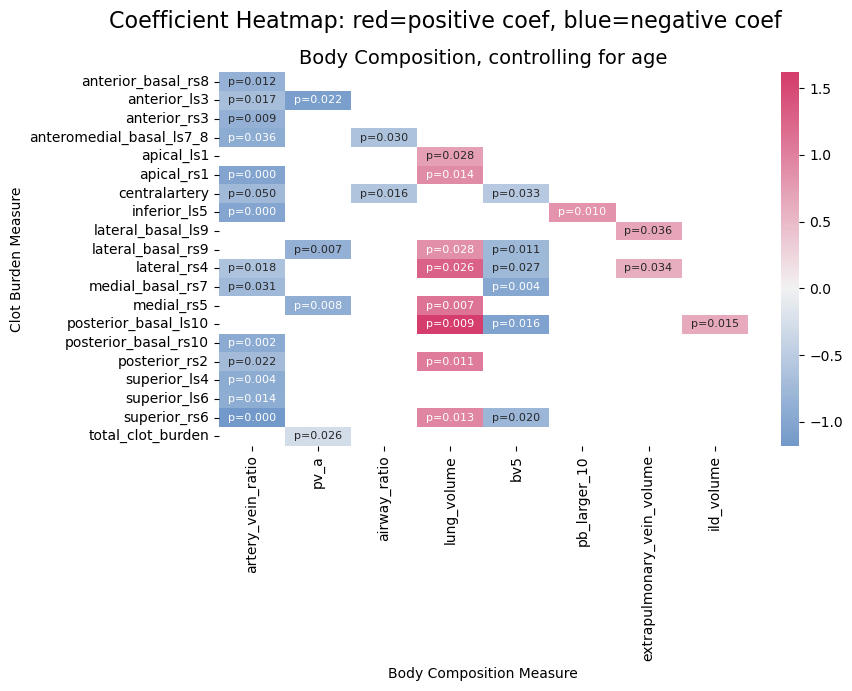

In [16]:
ols = ols_regression(
	Xdata=X,
	Ydata=y,
	targets=y.columns,
	features=cardio_features,
	controls=['age']
)

plot_subtitle = 'Body Composition, controlling for age'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[age].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[age].csv')

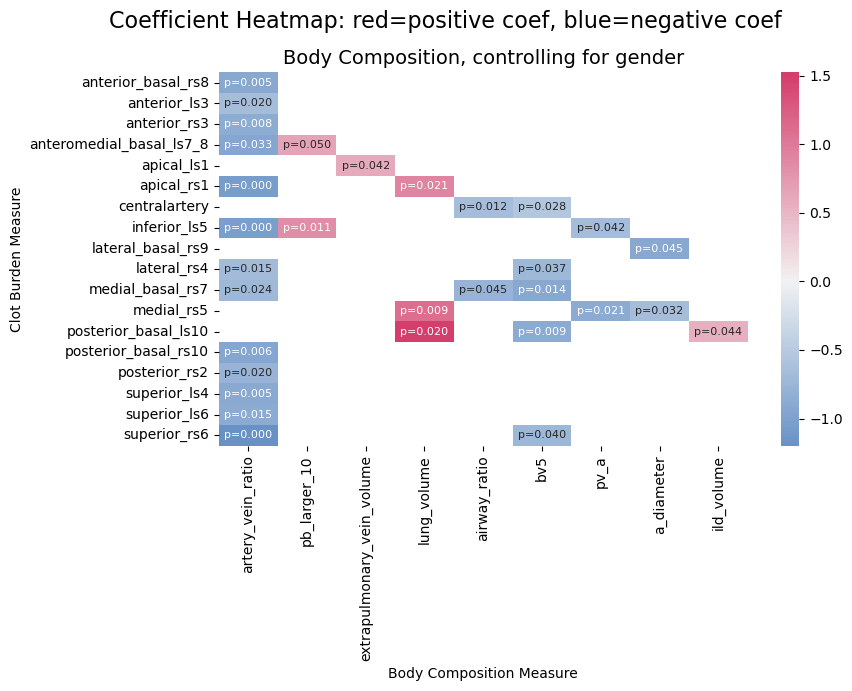

In [17]:
ols = ols_regression(
	Xdata=X,
	Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for gender'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[gender_cl_Male].csv')

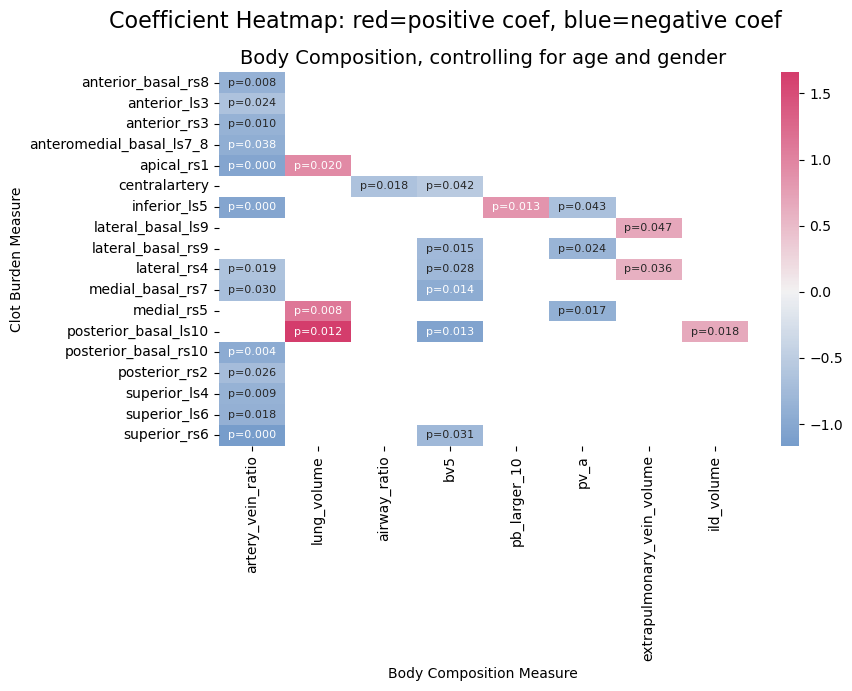

In [18]:
ols = ols_regression(
	Xdata=X,
	Ydata=y, 
	targets=y.columns,
	features=cardio_features,
	controls=['age', 'gender_cl_Male']
)

plot_subtitle = 'Body Composition, controlling for age and gender'

ols_heatmap(ols, '../figures/heatmap_OLS_cardio_controls=[age, gender_cl_Male].png', plot_subtitle)

ols_identify_significant(ols, SIGNIFICANCE_CUTOFF, '../output/regressions/OLS_cardio_controls=[age, gender_cl_Male].csv')

## Multivariable Regressions

### Feature Selection

#### Recursive Feature Selection

In [49]:
rfecv_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	rfecv = RFECV(
		estimator=ols,
		step=1,
		scoring='neg_mean_squared_error',
		cv=10
	)

	rfecv.fit(X[cardio_features], y[target])
	rfecv_results[target] = list(rfecv.get_feature_names_out())

rfecv_results

{'total_clot_burden': ['lung_volume',
  'extrapulmonary_vein_volume',
  'artery_vein_ratio',
  'bv5',
  'pb_larger_10',
  'a_diameter',
  'pv_a',
  'heart_volume',
  'airway_ratio'],
 'centralartery': ['lung_volume', 'artery_vein_ratio', 'bv5', 'airway_ratio'],
 'apical_rs1': ['lung_volume', 'artery_vein_ratio'],
 'posterior_rs2': ['lung_volume', 'artery_vein_ratio', 'pv_a'],
 'anterior_rs3': ['artery_vein_ratio'],
 'lateral_rs4': ['lung_volume', 'artery_vein_ratio', 'bv5', 'a_diameter'],
 'medial_rs5': ['lung_volume', 'artery_vein_ratio'],
 'superior_rs6': ['lung_volume', 'artery_vein_ratio', 'bv5'],
 'medial_basal_rs7': ['lung_volume',
  'artery_vein_ratio',
  'bv5',
  'pb_larger_10',
  'a_diameter',
  'pv_a',
  'airway_ratio',
  'ild_volume'],
 'anterior_basal_rs8': ['artery_vein_ratio'],
 'lateral_basal_rs9': ['emphysema_volume_950hu',
  'lung_volume',
  'extrapulmonary_artery_volume',
  'extrapulmonary_vein_volume',
  'artery_vein_ratio',
  'bv5',
  'pb_larger_10',
  'a_diameter',

In [53]:
rfecv_regressions = pd.DataFrame()

for target in y.columns:
	x_vars = rfecv_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	rfecv_regressions = pd.concat((rfecv_regressions, res), axis=0)
	
rfecv_regressions.to_csv('../output/regressions/ols_rfecv_selected_cardio.csv')
rfecv_regressions

coef          pval  nobs  \
y                    X                                                          
total_clot_burden    const                      -0.124215  4.110341e-01  90.0   
                     lung_volume                 0.131570  2.690647e-01  90.0   
                     extrapulmonary_vein_volume  0.205190  1.309043e-01  90.0   
                     artery_vein_ratio          -0.342598  3.736027e-02  90.0   
                     bv5                        -0.195339  5.195887e-02  90.0   
...                                                   ...           ...   ...   
posterior_basal_ls10 const                      -2.788835  5.655120e-21  90.0   
                     lung_volume                 1.117814  1.063014e-04  90.0   
                     bv5                        -0.749198  2.246842e-03  90.0   
                     pv_a                       -0.631018  6.314877e-03  90.0   
                     ild_volume                  0.506208  1.154039e-02  90.0   

                                                signif  
y                    X                                  
total_clot_burden    const                              
                     lung_volume                        
                     extrapulmonary_vein_volume         
                     artery_vein_ratio               *  
                     bv5                                
...                                                ...  
posterior_basal_ls10 const                         ***  
                     lung_volume                   ***  
                     bv5                            **  
                     pv_a                           **  
                     ild_volume                      *  

[105 rows x 4 columns]

#### Sequential Feature Selection

In [51]:
sfs_fwd_results = dict()

for target in y.columns:
	ols = LinearRegression(fit_intercept=True)

	sfs_fwd = SequentialFeatureSelector(
		estimator=ols,
		n_features_to_select='auto',
		tol=0.01,
		scoring='neg_mean_squared_error',
		direction='forward',
		cv=10
	)

	sfs_fwd.fit(X[cardio_features], y[target])
	sfs_fwd_results[target] = sfs_fwd.get_feature_names_out()

sfs_fwd_results

{'total_clot_burden': array(['lung_volume', 'artery_vein_ratio', 'bv5', 'airway_ratio'],
       dtype=object),
 'centralartery': array(['artery_vein_ratio', 'bv5', 'airway_ratio'], dtype=object),
 'apical_rs1': array(['emphysema_volume_950hu', 'lung_volume',
        'extrapulmonary_vein_volume', 'artery_vein_ratio', 'bv5',
        'a_diameter'], dtype=object),
 'posterior_rs2': array(['lung_volume', 'artery_vein_ratio', 'bv5', 'pb_larger_10',
        'a_diameter', 'pv_a'], dtype=object),
 'anterior_rs3': array(['extrapulmonary_vein_volume', 'artery_vein_ratio', 'heart_volume',
        'airway_ratio'], dtype=object),
 'lateral_rs4': array(['lung_volume', 'extrapulmonary_vein_volume', 'artery_vein_ratio',
        'bv5', 'a_diameter'], dtype=object),
 'medial_rs5': array(['lung_volume', 'artery_vein_ratio', 'a_diameter', 'pv_a'],
       dtype=object),
 'superior_rs6': array(['lung_volume', 'artery_vein_ratio', 'bv5', 'airway_ratio'],
       dtype=object),
 'medial_basal_rs7': array(['arte

In [54]:
sfs_fwd_regressions = pd.DataFrame()

for target in model_config.num_targets:
	x_vars = sfs_fwd_results[target]
	X_temp = sm.add_constant(X.loc[:, x_vars])
	y_temp = y.loc[:, target]
	fitted_model = sm.OLS(y_temp, X_temp).fit(cov_type='HC3')

	res = pd.DataFrame({
		'coef': fitted_model.params,
		'pval': fitted_model.pvalues,
		'nobs': fitted_model.nobs,
	})

	res['signif'] = res.pval.apply(reg.add_significance)
	res.index = pd.MultiIndex.from_tuples(
		list(zip([target for _ in range(res.shape[0])], res.index)),
		names=('y', 'X')
	)
	res.index.names
	sfs_fwd_regressions = pd.concat((sfs_fwd_regressions, res), axis=0)
	
sfs_fwd_regressions.to_csv('../output/regressions/ols_sfs_fwd_selected_cardio.csv')
sfs_fwd_regressions

coef          pval  nobs signif
y                    X                                                     
total_clot_burden    const             -0.123206  4.061384e-01  90.0       
                     lung_volume        0.218194  6.120133e-03  90.0     **
                     artery_vein_ratio -0.397158  1.672226e-02  90.0      *
                     bv5               -0.315096  2.253415e-03  90.0     **
                     airway_ratio      -0.458454  1.316600e-02  90.0      *
...                                          ...           ...   ...    ...
posterior_basal_ls10 const             -2.788835  5.655120e-21  90.0    ***
                     lung_volume        1.117814  1.063014e-04  90.0    ***
                     bv5               -0.749198  2.246842e-03  90.0     **
                     pv_a              -0.631018  6.314877e-03  90.0     **
                     ild_volume         0.506208  1.154039e-02  90.0      *

[98 rows x 4 columns]